## Notebook for models without the decades 1960 and 1970

In [1]:
import psycopg2 as pg
import pandas as pd

# We are also going to do some basic viz
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.model_selection import GridSearchCV

#Import all the models that I will use
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
import xgboost as xgb

In [2]:
connection_args = {
    'host': 'localhost', 
    'dbname': 'song_classifier',
}
connection = pg.connect(**connection_args)

In [3]:
query = "SELECT * FROM songs_of_the_80s\
        UNION\
        SELECT * FROM songs_of_the_90s\
        UNION\
        SELECT * FROM songs_of_the_00s\
        UNION\
        SELECT * FROM songs_of_the_10s;"

songs_df = pd.read_sql(query, connection)
songs_df.shape

(24698, 20)

* **In deleting the 1960s and 1970s I lost around 18000 rows of data but due to the lower scores of those decade and still having nearly 25000 records I will continue to work in this time frame**

In [4]:
# Checking to make sure the classes are still balanced
songs_df['target'].mean()

0.5

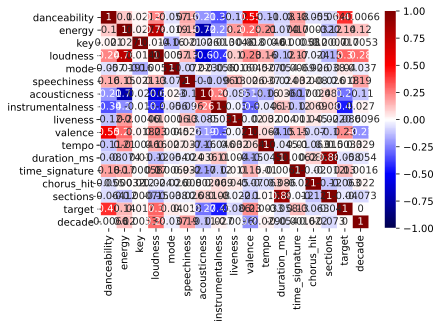

In [5]:
sns.heatmap(songs_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [72]:
X = songs_df.drop(columns=['target','uri','artist','track','decade'])
y = songs_df['target'].values

In [73]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### kNN

In [32]:
# Using grid search to find the best k
ks = list(range(1,51))

param_grid = dict(n_neighbors = ks)

nn = KNeighborsClassifier()

grid = GridSearchCV(nn, param_grid, cv = 5, scoring = 'accuracy',verbose=1,n_jobs=-1)
grid.fit(X_train_scaled,y_train)

grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished


{'n_neighbors': 14}

In [33]:
nn = KNeighborsClassifier(n_neighbors=14,n_jobs=-1)
nn_classifier = nn.fit(X_train_scaled,y_train)
y_pred_nn = nn.predict(X_val_scaled)
print('kNN train score: {:.3f}'.format(nn.score(X_train_scaled,y_train)))
print('kNN test score: {:.3f}'.format(nn.score(X_val_scaled,y_val)))

kNN train score: 0.808
kNN test score: 0.790


In [34]:
print(classification_report(y_val, y_pred_nn))

              precision    recall  f1-score   support

           0       0.86      0.69      0.77      2944
           1       0.74      0.89      0.81      2984

    accuracy                           0.79      5928
   macro avg       0.80      0.79      0.79      5928
weighted avg       0.80      0.79      0.79      5928



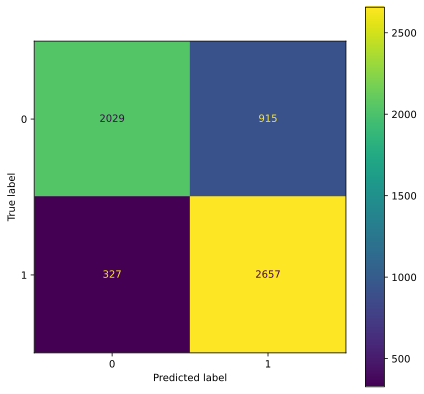

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn, X_val_scaled, y_val, ax=ax);

## Logistic Regression

In [13]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      2944
           1       0.76      0.85      0.80      2984

    accuracy                           0.78      5928
   macro avg       0.79      0.78      0.78      5928
weighted avg       0.79      0.78      0.78      5928



In [14]:
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

Logistic Regression train score: 0.775
Logistic Regression test score: 0.785


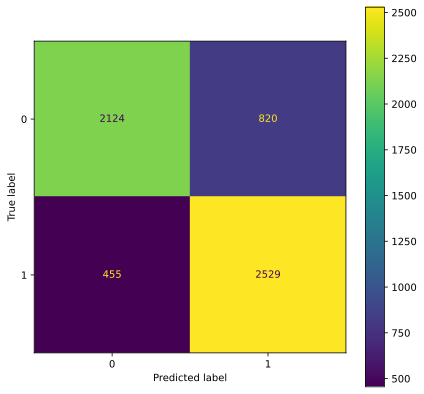

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax);

### Logistic Regression w/ grid search

In [89]:
import numpy as np
lr = LogisticRegression()
param_grid = [
    {'penalty' : ['l1', 'l2','none'],
    'C' : np.logspace(-4, 4, 20),}
]
clf = GridSearchCV(estimator = lr , param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train_scaled, y_train)
clf.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    5.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.2s finished


{'C': 0.0001, 'penalty': 'l2'}

In [91]:
lr = LogisticRegression(C = 0.0001,penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.49      0.59      0.54      2966
           1       0.48      0.38      0.43      2962

    accuracy                           0.49      5928
   macro avg       0.49      0.49      0.48      5928
weighted avg       0.49      0.49      0.48      5928



/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


* Score substaniall

### SVC

In [16]:
svc = SVC(probability=True)
svc.fit(X_train_scaled,y_train)
y_pred_svc = svc.predict(X_val_scaled)

print('SVC train score: {:.3f}'.format(svc.score(X_train_scaled,y_train)))
print('SVC test score: {:.3f}'.format(svc.score(X_val_scaled,y_val)))
print(classification_report(y_val, y_pred_svc))

SVC train score: 0.827
SVC test score: 0.820
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      2944
           1       0.78      0.90      0.83      2984

    accuracy                           0.82      5928
   macro avg       0.83      0.82      0.82      5928
weighted avg       0.83      0.82      0.82      5928



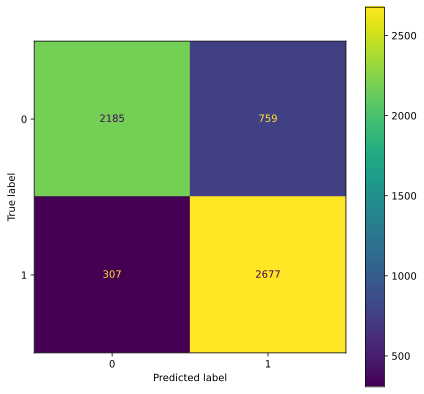

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, X_val_scaled, y_val, ax=ax);

### GaussianNB

In [18]:
gb = GaussianNB()
gb.fit(X_train_scaled,y_train)
y_pred_gb = gb.predict(X_val_scaled)

print('Naive Bayes train score: {:.3f}'.format(gb.score(X_train_scaled,y_train)))
print('Naive Bayes test score: {:.3f}'.format(gb.score(X_val_scaled,y_val)))

print(classification_report(y_val, y_pred_gb))

Naive Bayes train score: 0.740
Naive Bayes test score: 0.748
              precision    recall  f1-score   support

           0       0.85      0.60      0.70      2944
           1       0.69      0.89      0.78      2984

    accuracy                           0.75      5928
   macro avg       0.77      0.75      0.74      5928
weighted avg       0.77      0.75      0.74      5928



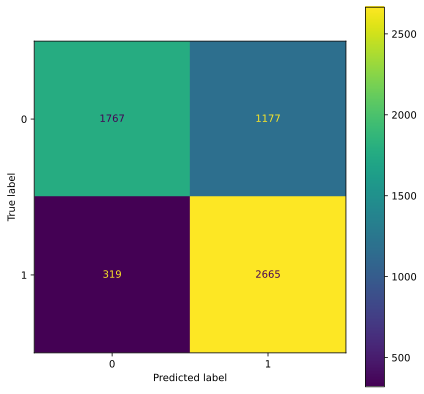

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gb, X_val_scaled, y_val, ax=ax);

### Decision Tree

In [20]:
dcf = DecisionTreeClassifier(random_state=0)
dcf.fit(X_train_scaled,y_train)
y_pred_dcf = dcf.predict(X_val_scaled)
print('Decision Tree train score: {:.3f}'.format(dcf.score(X_train_scaled,y_train)))
print('Decision Tree test score: {:.3f}'.format(dcf.score(X_val_scaled,y_val)))

Decision Tree train score: 0.999
Decision Tree test score: 0.741


In [21]:
print(classification_report(y_val, y_pred_gb))

              precision    recall  f1-score   support

           0       0.85      0.60      0.70      2944
           1       0.69      0.89      0.78      2984

    accuracy                           0.75      5928
   macro avg       0.77      0.75      0.74      5928
weighted avg       0.77      0.75      0.74      5928



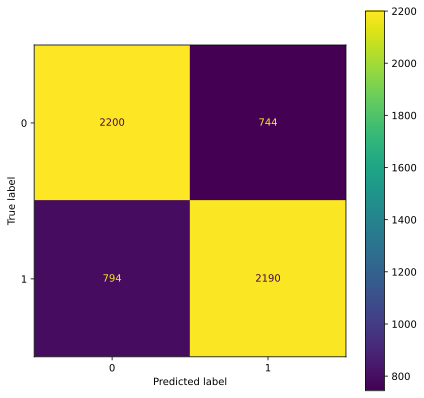

In [22]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dcf, X_val_scaled, y_val, ax=ax);

### RandomForest

#### Random Forest HyperTuning 

In [75]:
param_grid = {
    'max_depth': range(0,100),
    'min_samples_leaf': range(0,11),
}
rf = RandomForestClassifier()


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

Fitting 3 folds for each of 1100 candidates, totalling 3300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s


KeyboardInterrupt: 

In [82]:
rfc = RandomForestClassifier(bootstrap = True,min_samples_leaf=4,max_depth=110,max_features=2,min_samples_split=8,n_estimators=200)
rfc.fit(X_train_scaled,y_train)
y_pred_rfc = rfc.predict(X_val_scaled)

print('Random Forest train score: {:.3f}'.format(rfc.score(X_train_scaled,y_train)))
print('Random Forest test score: {:.3f}'.format(rfc.score(X_val_scaled,y_val)))

Random Forest train score: 0.600
Random Forest test score: 0.493


#### Random Forest No Hyper tuning

In [23]:
rfc = RandomForestClassifier(random_state=0,min_samples_leaf=8)
rfc.fit(X_train_scaled,y_train)
y_pred_rfc = rfc.predict(X_val_scaled)

print('Random Forest train score: {:.3f}'.format(rfc.score(X_train_scaled,y_train)))
print('Random Forest test score: {:.3f}'.format(rfc.score(X_val_scaled,y_val)))

Random Forest train score: 0.882
Random Forest test score: 0.822


In [65]:
rfc.feature_importances_

array([0.14690653, 0.08054152, 0.01448691, 0.06807133, 0.00482103,
       0.04051671, 0.13056108, 0.25109132, 0.0294946 , 0.05899514,
       0.02844065, 0.08955516, 0.00422309, 0.02721658, 0.02507836])

In [70]:
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       ...
       'The Prisoners', 'The Stooges', 'The Weeknd', 'Tim McGraw',
       'Toby Keith', 'Ton Steine Scherben', 'U2', 'Usher', 'Whitney Houston',
       'Éric Serra'],
      dtype='object', length=116)

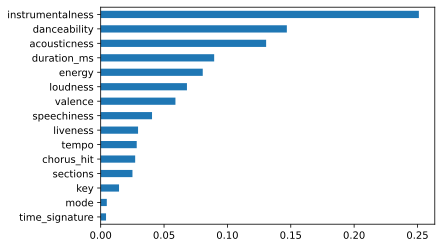

In [76]:
(pd.Series(rfc.feature_importances_, index=X.columns)
   .nlargest(16)
   .plot(kind='barh')).invert_yaxis()

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2944
           1       0.80      0.86      0.83      2984

    accuracy                           0.82      5928
   macro avg       0.82      0.82      0.82      5928
weighted avg       0.82      0.82      0.82      5928



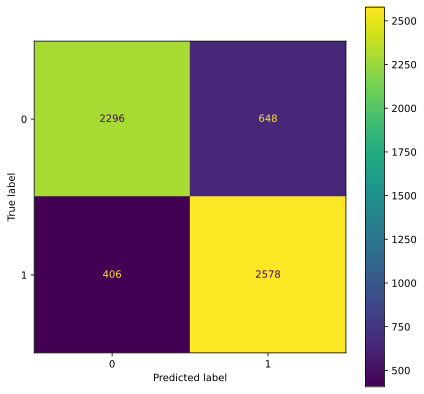

In [24]:
print(classification_report(y_val, y_pred_rfc))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rfc, X_val_scaled, y_val, ax=ax);

In [36]:
# Load pre-trained/tuned models

model_names = ["lr", "nn", "svc", "rfc"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [37]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_scaled, y_val)}')

lr score: 0.784919028340081
nn score: 0.7904858299595142
svc score: 0.8201754385964912
rfc score: 0.8221997300944669


In [38]:
vc_hard = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
vc_hard.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(penalty='none')),
                             ('nn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=14)),
                             ('svc', SVC(probability=True)),
                             ('rfc',
                              RandomForestClassifier(min_samples_leaf=8,
                                                     random_state=0))],
                 n_jobs=-1)

In [39]:
y_pred = vc_hard.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.8203441295546559

In [40]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2944
           1       0.79      0.87      0.83      2984

    accuracy                           0.82      5928
   macro avg       0.82      0.82      0.82      5928
weighted avg       0.82      0.82      0.82      5928



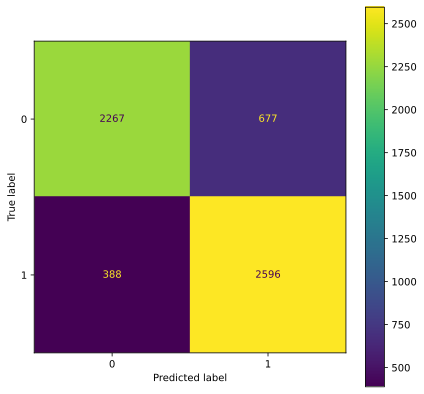

In [41]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(vc_hard, X_val_scaled, y_val, ax=ax);

## Voting classifier soft voting

In [42]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(penalty='none')),
                             ('nn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=14)),
                             ('svc', SVC(probability=True)),
                             ('rfc',
                              RandomForestClassifier(min_samples_leaf=8,
                                                     random_state=0))],
                 n_jobs=-1, voting='soft')

In [43]:
y_pred = voting_classifer.predict(X_val_scaled)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.8183198380566802
              precision    recall  f1-score   support

           0       0.87      0.75      0.80      2944
           1       0.78      0.89      0.83      2984

    accuracy                           0.82      5928
   macro avg       0.82      0.82      0.82      5928
weighted avg       0.82      0.82      0.82      5928



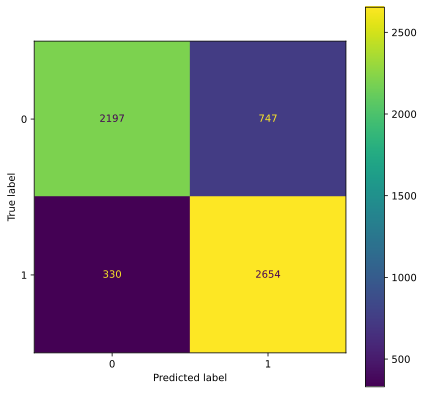

In [45]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(voting_classifer, X_val_scaled, y_val, ax=ax);

## Plot ROC

In [46]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, nn.predict_proba(X_val_scaled)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, gb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dcf.predict_proba(X_val)[:,1])

KNN ROC AUC score =  0.8586324755580488
Logit ROC AUC score =  0.8569186817920212
Naive Bayes ROC AUC score =  0.8384780536957979
Random Forest ROC AUC score =  0.8991840654687318
Support Vector Machines ROC AUC score =  0.8901222621189824
Decision Tree ROC AUC score =  0.7408036475332206


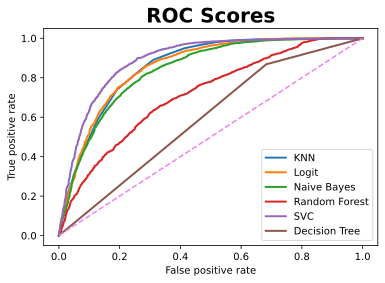

In [47]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['KNN', 'Logit', 'Naive Bayes', 'Random Forest','SVC', 'Decision Tree'])
print('KNN ROC AUC score = ', roc_auc_score(y_val, nn.predict_proba(X_val_scaled)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_val, gb.predict_proba(X_val_scaled)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_val, rfc.predict_proba(X_val_scaled)[:,1]))
print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_val, dcf.predict_proba(X_val_scaled)[:,1]))

## Try Models with Top 100 Artist by Value Counts

* **First I'm gonna plot the top 10 artist and there hit/flop counts**

In [145]:
top_twenty = songs_df['artist'].value_counts().iloc[:21]
mask = songs_df['artist'].isin(top_twenty.index)

/Users/sibongiletoure/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


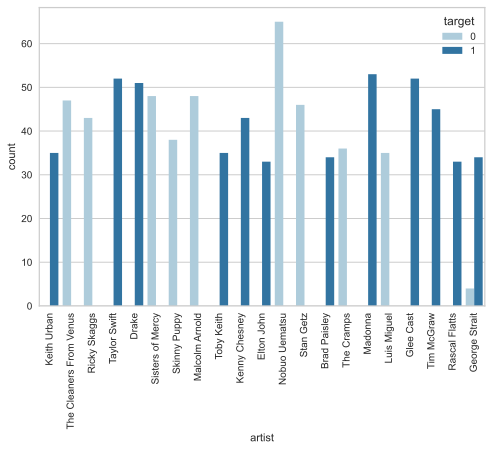

In [146]:
sns.countplot(songs_df['artist'][mask],hue=songs_df['target'],palette='Paired');
plt.xticks(rotation=90);

In [4]:
top_hundred = songs_df['artist'].value_counts().iloc[:101]
mask = songs_df['artist'].isin(top_hundred.index)

In [5]:
artist_dummies = pd.get_dummies(songs_df['artist'][mask])

In [6]:
songs_df = pd.concat([songs_df, artist_dummies], axis=1)

In [7]:
X = songs_df.drop(columns=['target','uri','track','artist','decade'])
y = songs_df['target'].values

In [8]:
X.fillna(0,inplace=True)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.3)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Logisitc Regression w/ top 100 artist

In [11]:
lr = LogisticRegression(penalty='none')

lr.fit(X_train_scaled, y_train)

y_preds = lr.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      2964
           1       0.77      0.86      0.81      2964

    accuracy                           0.80      5928
   macro avg       0.81      0.80      0.80      5928
weighted avg       0.81      0.80      0.80      5928



In [12]:
print('Logistic Regression train score: {:.3f}'.format(lr.score(X_train_scaled,y_train)))
print('Logistic Regression test score: {:.3f}'.format(lr.score(X_val_scaled,y_val)))

Logistic Regression train score: 0.800
Logistic Regression test score: 0.802


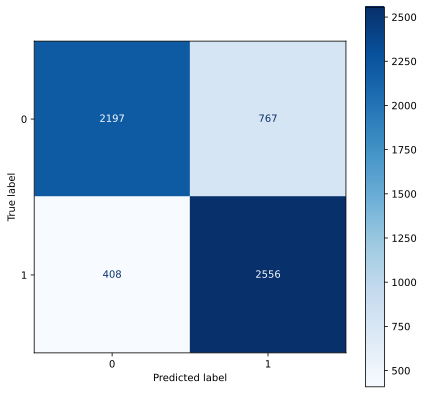

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues );

### kNN w/ top 100

In [94]:
ks = list(range(1,51))

param_grid = dict(n_neighbors = ks)

nn = KNeighborsClassifier()

grid = GridSearchCV(nn, param_grid, cv = 5, scoring = 'accuracy',verbose=1,n_jobs=-1)
grid.fit(X_train_scaled,y_train)

grid.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.9min finished


{'n_neighbors': 14}

In [14]:
nn = KNeighborsClassifier(n_neighbors=14,n_jobs=-1)
nn_classifier = nn.fit(X_train_scaled,y_train)
y_pred_nn = nn.predict(X_val_scaled)
print('kNN train score: {:.3f}'.format(nn.score(X_train_scaled,y_train)))
print('kNN test score: {:.3f}'.format(nn.score(X_val_scaled,y_val)))

kNN train score: 0.830
kNN test score: 0.803


              precision    recall  f1-score   support

           0       0.87      0.71      0.78      2964
           1       0.76      0.89      0.82      2964

    accuracy                           0.80      5928
   macro avg       0.81      0.80      0.80      5928
weighted avg       0.81      0.80      0.80      5928



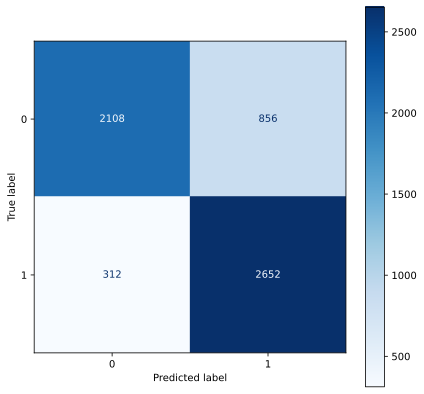

In [15]:
print(classification_report(y_val, y_pred_nn))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(nn, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues );

### SVC

In [16]:
svc = SVC(probability=True)
svc.fit(X_train_scaled,y_train)
y_pred_svc = svc.predict(X_val_scaled)

print('SVC train score: {:.3f}'.format(svc.score(X_train_scaled,y_train)))
print('SVC test score: {:.3f}'.format(svc.score(X_val_scaled,y_val)))
print(classification_report(y_val, y_pred_svc))

SVC train score: 0.822
SVC test score: 0.818
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      2964
           1       0.77      0.92      0.83      2964

    accuracy                           0.82      5928
   macro avg       0.83      0.82      0.82      5928
weighted avg       0.83      0.82      0.82      5928



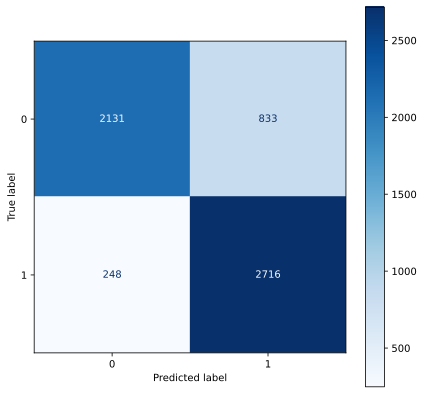

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(svc, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues);

### Decision Tree

In [19]:
dcf = DecisionTreeClassifier(random_state=0)
dcf.fit(X_train_scaled,y_train)
y_pred_dcf = dcf.predict(X_val_scaled)
print('Decision Tree train score: {:.3f}'.format(dcf.score(X_train_scaled,y_train)))
print('Decision Tree test score: {:.3f}'.format(dcf.score(X_val_scaled,y_val)))

Decision Tree train score: 0.999
Decision Tree test score: 0.745


In [20]:
print(classification_report(y_val, y_pred_dcf))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      2964
           1       0.75      0.74      0.74      2964

    accuracy                           0.74      5928
   macro avg       0.74      0.74      0.74      5928
weighted avg       0.74      0.74      0.74      5928



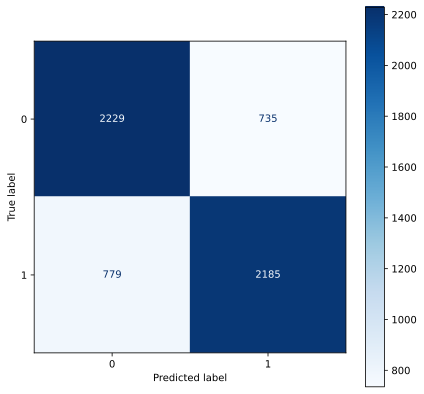

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(dcf, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues);

### Random Forest

In [22]:
rfc = RandomForestClassifier(random_state=0,min_samples_leaf=7)
rfc.fit(X_train_scaled,y_train)
y_pred_rfc = rfc.predict(X_val_scaled)

print('Random Forest train score: {:.3f}'.format(rfc.score(X_train_scaled,y_train)))
print('Random Forest test score: {:.3f}'.format(rfc.score(X_val_scaled,y_val)))

Random Forest train score: 0.835
Random Forest test score: 0.813


              precision    recall  f1-score   support

           0       0.85      0.76      0.80      2964
           1       0.78      0.87      0.82      2964

    accuracy                           0.81      5928
   macro avg       0.82      0.81      0.81      5928
weighted avg       0.82      0.81      0.81      5928



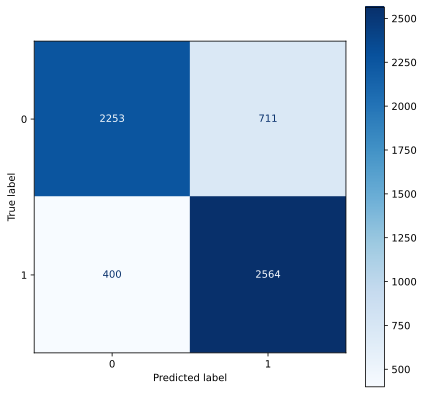

In [23]:
print(classification_report(y_val, y_pred_rfc))
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rfc, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues);

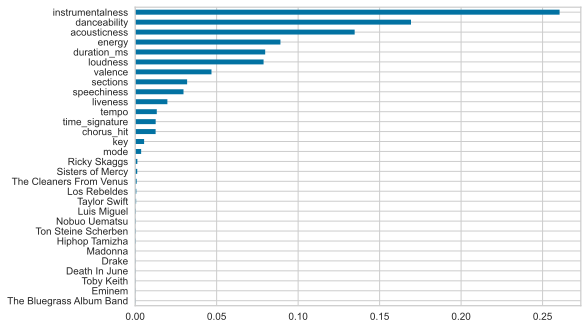

In [59]:
(pd.Series(rfc.feature_importances_, index=X.columns)
   .nlargest(30)
   .plot(kind='barh')).invert_yaxis()

### GaussianNB

In [24]:
gb = GaussianNB()
gb.fit(X_train_scaled,y_train)
y_pred_gb = gb.predict(X_val_scaled)

print('Naive Bayes train score: {:.3f}'.format(gb.score(X_train_scaled,y_train)))
print('Naive Bayes test score: {:.3f}'.format(gb.score(X_val_scaled,y_val)))

print(classification_report(y_val, y_pred_gb))

Naive Bayes train score: 0.558
Naive Bayes test score: 0.564
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      2964
           1       0.99      0.13      0.23      2964

    accuracy                           0.56      5928
   macro avg       0.76      0.56      0.46      5928
weighted avg       0.76      0.56      0.46      5928



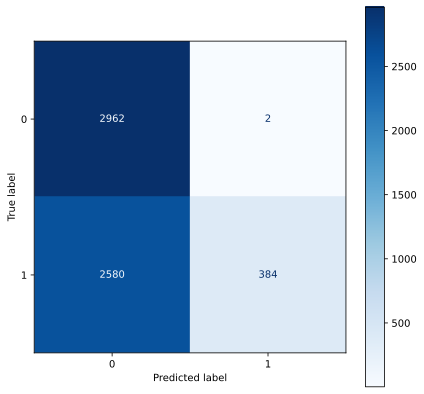

In [25]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(gb, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues);

### Ensemble Model w/ 'hard voting'

In [26]:
# Load pre-trained/tuned models

model_names = ["lr", "gb","nn", "svc", "rfc"]

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [27]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_val_scaled, y_val)}')

lr score: 0.8017881241565452
gb score: 0.5644399460188934
nn score: 0.8029689608636977
svc score: 0.8176450742240216
rfc score: 0.8125843454790823


In [28]:
# Change spelling of classifier

vc_hard = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
vc_hard.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(penalty='none')),
                             ('gb', GaussianNB()),
                             ('nn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=14)),
                             ('svc', SVC(probability=True)),
                             ('rfc',
                              RandomForestClassifier(min_samples_leaf=7,
                                                     random_state=0))],
                 n_jobs=-1)

In [29]:
y_pred = vc_hard.predict(X_val_scaled)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.823549257759784
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      2964
           1       0.79      0.88      0.83      2964

    accuracy                           0.82      5928
   macro avg       0.83      0.82      0.82      5928
weighted avg       0.83      0.82      0.82      5928



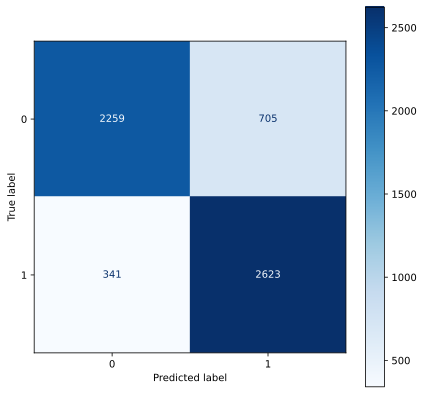

In [30]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(vc_hard, X_val_scaled, y_val, ax=ax, cmap=plt.cm.Blues);

In [31]:
vc_hard.estimators_

[LogisticRegression(penalty='none'),
 GaussianNB(),
 KNeighborsClassifier(n_jobs=-1, n_neighbors=14),
 SVC(probability=True),
 RandomForestClassifier(min_samples_leaf=7, random_state=0)]

#### Ensemble model w/ 'soft voting'

In [32]:
voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
voting_classifier.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(penalty='none')),
                             ('gb', GaussianNB()),
                             ('nn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=14)),
                             ('svc', SVC(probability=True)),
                             ('rfc',
                              RandomForestClassifier(min_samples_leaf=7,
                                                     random_state=0))],
                 n_jobs=-1, voting='soft')

In [33]:
y_pred = voting_classifier.predict(X_val_scaled)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.8139338731443995
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      2964
           1       0.82      0.80      0.81      2964

    accuracy                           0.81      5928
   macro avg       0.81      0.81      0.81      5928
weighted avg       0.81      0.81      0.81      5928



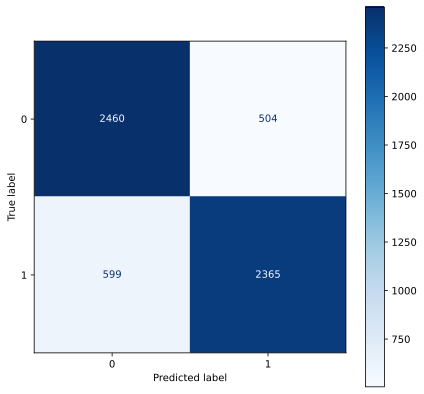

In [34]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(voting_classifier, X_val_scaled, y_val, ax=ax,cmap=plt.cm.Blues);

### Plot ROC curve w/ top 100 artist

In [83]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, nn.predict_proba(X_val_scaled)[:,1])
fpr_log, tpr_log, thresholds_log = roc_curve(y_val, lr.predict_proba(X_val_scaled)[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, gb.predict_proba(X_val_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_val, svc.predict_proba(X_val_scaled)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, dcf.predict_proba(X_val_scaled)[:,1])
fpr_vc,tpr_vc,thresholds_vc = roc_curve(y_val, voting_classifer.predict_proba(X_val_scaled)[:,1])

KNN ROC AUC score =  0.8701238987135189
Logit ROC AUC score =  0.8678333275654487
Naive Bayes ROC AUC score =  0.8616610460149685
Random Forest ROC AUC score =  0.8727995899944809
Support Vector Machines ROC AUC score =  0.8784525911765938
Decision Tree ROC AUC score =  0.7429241148270453
Voting Classifier ROC AUC score =  0.8926713562603709


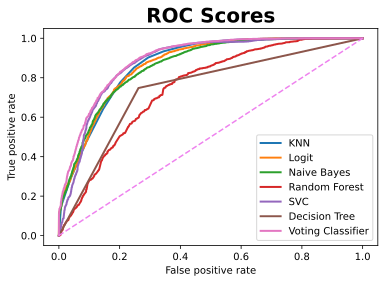

In [84]:
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot(fpr_nb, tpr_nb,lw=2)
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot(fpr_svc, tpr_svc,lw=2)
plt.plot(fpr_dt, tpr_dt,lw=2)
plt.plot(fpr_vc, tpr_vc,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
plt.legend(['KNN', 'Logit', 'Naive Bayes', 'Random Forest','SVC', 'Decision Tree','Voting Classifier'])
print('KNN ROC AUC score = ', roc_auc_score(y_val, nn.predict_proba(X_val_scaled)[:,1]))
print('Logit ROC AUC score = ', roc_auc_score(y_val, lr.predict_proba(X_val_scaled)[:,1]))
print('Naive Bayes ROC AUC score = ', roc_auc_score(y_val, gb.predict_proba(X_val_scaled)[:,1]))
print('Random Forest ROC AUC score = ', roc_auc_score(y_val, rfc.predict_proba(X_val_scaled)[:,1]))
print('Support Vector Machines ROC AUC score = ', roc_auc_score(y_val, svc.predict_proba(X_val_scaled)[:,1]))
print('Decision Tree ROC AUC score = ', roc_auc_score(y_val, dcf.predict_proba(X_val_scaled)[:,1]))
print('Voting Classifier ROC AUC score = ', roc_auc_score(y_val, voting_classifer.predict_proba(X_val_scaled)[:,1]))

#### XGBoost

In [72]:
gbm = xgb.XGBClassifier( 
                        n_estimators=10000,
                        max_depth=4,
                        objective='binary:logistic', 
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc', 
                    early_stopping_rounds=50,
                    verbose=False
                   )
print(accuracy_score(y_train, gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)))
print(accuracy_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))
print(classification_report(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

0.8571945046999276
0.8292847503373819
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2964
           1       0.79      0.89      0.84      2964

    accuracy                           0.83      5928
   macro avg       0.83      0.83      0.83      5928
weighted avg       0.83      0.83      0.83      5928



In [73]:
fpr_gbm,tpr_gbm,thresholds_gbm = roc_curve(y_val, gbm.predict_proba(X_val)[:,1])

XgBoost ROC AUC score =  0.8996101554233346


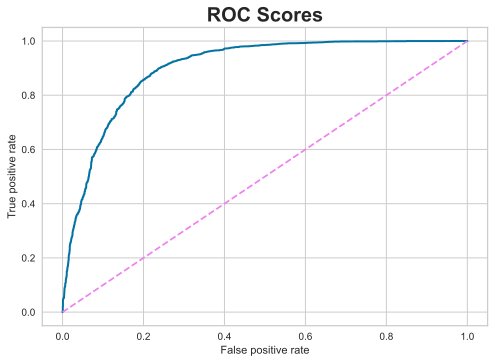

In [74]:
plt.plot(fpr_gbm, tpr_gbm,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Scores', fontweight='bold', fontsize=20);
print('XgBoost ROC AUC score = ', roc_auc_score(y_val, gbm.predict_proba(X_val)[:,1]))

### Top 3 Model 
* Voting Classfier w/ soft voting
* XGBoost
* Random Forest 

* XGBoost gave me the best overall score of 0.829 and an ROC of 0.892
* Voting classifier has a lower score at 0.813 and an ROC-AUC of 0.892 but it has better recall than XGBoost when it comes to predicting if a 'Flop' is really a 'Flop'
 